In [1]:
import prince # for multiple correspondence analysis
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [5]:
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('data/Customer_churn.csv')

In [6]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [8]:
senior = {0 : 'No',
         1 : 'Yes'}
df['SeniorCitizen'].replace(senior, inplace=True)

In [11]:
def tenure(data):
    if 0 < data  <= 24 :
        return 'Short'
    else:
        return 'Long'

df['tenure'] = df['tenure'].apply(tenure)

In [13]:
def charges(data):
    if 0 < data  <= 70 :
        return 'LowCharge'
    else:
        return 'HighCharge'

df['MonthlyCharges'] = df['MonthlyCharges'].apply(charges)

In [16]:
recode = {'No phone service' : 'No',
          'No internet service' : 'No',
            'Fiber optic' : 'Fberoptic',
            'Month-to-month' : 'MtM',
            'Two year' : 'TwoYr',
            'One year' : 'OneYr' ,
            'Electronic check' : 'check',
            'Mailed check' : 'check',
            'Bank transfer (automatic)' : 'automatic',
            'Credit card (automatic)' : 'automatic'
            }

df.replace(recode, inplace=True)

In [18]:
df.drop(['customerID', 'TotalCharges'], axis=1, inplace=True)

In [20]:
print("The original data set contains: {} rows and {} columns".format(df.shape[0], df.shape[1]))
print("Features of the original data set:\n", list(df.columns))

The original data set contains: 7043 rows and 19 columns
Features of the original data set:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Churn']


In [21]:
print("Number of categorical features : {}".format(len(df.select_dtypes(include=['object']).columns)))
print("Number of continuous features : {}".format(len(df.select_dtypes(include=['int64', 'float64']).columns)))

Number of categorical features : 19
Number of continuous features : 0


In [22]:
df.nunique()

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
tenure              2
PhoneService        2
MultipleLines       2
InternetService     3
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
Contract            3
PaperlessBilling    2
PaymentMethod       2
MonthlyCharges      2
Churn               2
dtype: int64

In [23]:
df.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [24]:
df.InternetService.value_counts()

Fberoptic    3096
DSL          2421
No           1526
Name: InternetService, dtype: int64

In [26]:
df.Contract.value_counts()

MtM      3875
TwoYr    1695
OneYr    1473
Name: Contract, dtype: int64

In [55]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,Short,No,No,DSL,No,Yes,No,No,No,No,MtM,Yes,check,LowCharge,No
1,Male,No,No,No,Long,Yes,No,DSL,Yes,No,Yes,No,No,No,OneYr,No,check,LowCharge,No


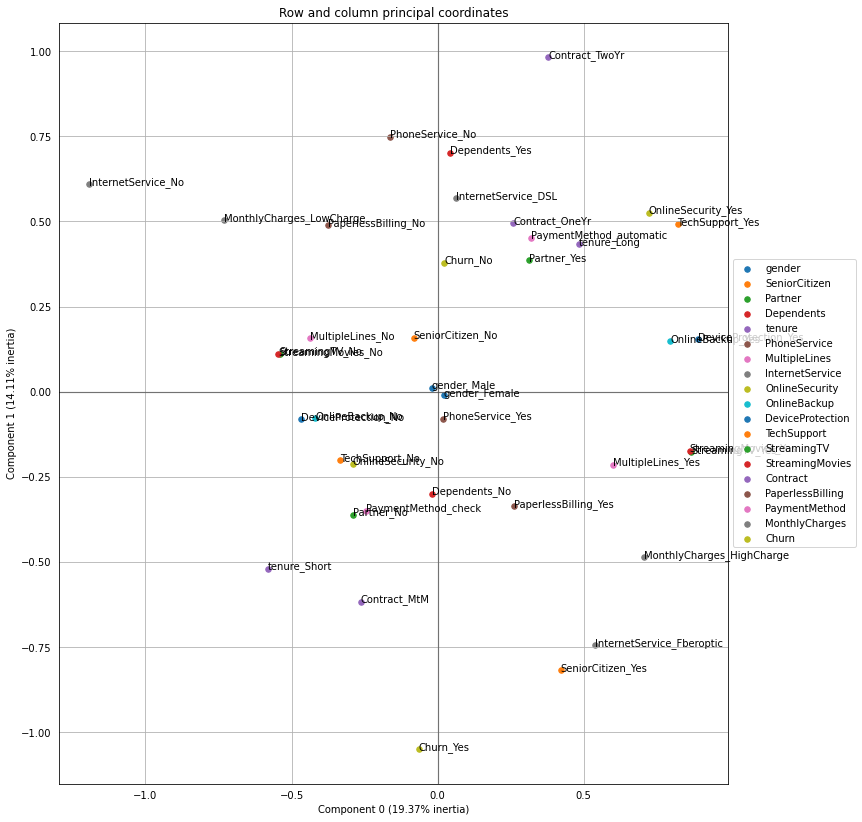

In [29]:
mca = prince.MCA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
        )
df_mca = mca.fit(df)

ax = df_mca.plot_coordinates(
        X=df,
        ax=None,
        figsize=(12, 14),
        show_row_points=False,
        row_points_size=0,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=30,
        show_column_labels=True,
        legend_n_cols=1).legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
df2 = pd.get_dummies(df, drop_first=True)

In [33]:
print(df2.shape)
print("The data set contains: {} rows and {} columns".format(df2.shape[0], df2.shape[1]))
print("Features after get_dummies:\n", list(df2.columns))

(7043, 21)
The data set contains: 7043 rows and 21 columns
Features after get_dummies:
 ['gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'tenure_Short', 'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fberoptic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_OneYr', 'Contract_TwoYr', 'PaperlessBilling_Yes', 'PaymentMethod_check', 'MonthlyCharges_LowCharge', 'Churn_Yes']


In [34]:
X = df2.drop('Churn_Yes', axis=1) # input categorical features
y = df2['Churn_Yes'] # target variable

In [38]:
# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)
# print feature scores
for i in range(len(sf_fit.scores_)):
    print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))

 gender_Male: 0.258699
 SeniorCitizen_Yes: 134.351545
 Partner_Yes: 82.412083
 Dependents_Yes: 133.036443
 tenure_Short: 372.654914
 PhoneService_Yes: 0.097261
 MultipleLines_Yes: 6.548512
 InternetService_Fberoptic: 374.476216
 InternetService_No: 286.520193
 OnlineSecurity_Yes: 147.295858
 OnlineBackup_Yes: 31.217694
 DeviceProtection_Yes: 20.226662
 TechSupport_Yes: 135.559783
 StreamingTV_Yes: 17.334235
 StreamingMovies_Yes: 16.242531
 Contract_OneYr: 176.123171
 Contract_TwoYr: 488.578090
 PaperlessBilling_Yes: 105.680863
 PaymentMethod_check: 135.084515
 MonthlyCharges_LowCharge: 148.208006


/opt/tljh/user/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


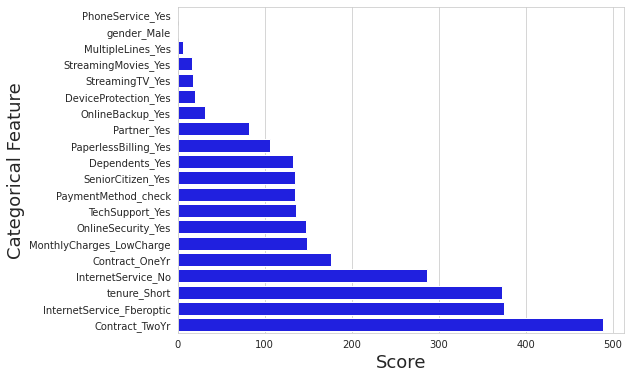

In [42]:
# plot the scores
plt.figure(figsize=(8,6))
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=True)
sns.barplot(datset['scores'], datset['feature'], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show();

In [43]:
X1 = df.drop('Churn', axis=1) # input features
y1 = df['Churn'] # target variable

In [44]:
oe = OrdinalEncoder()
oe.fit(X1)
X_enc = oe.transform(X1)

# prepare target variable
le = LabelEncoder()
le.fit(y1)
y_enc = le.transform(y1)

In [51]:
# feature selection
sf = SelectKBest(chi2, k='all')
sf_fit1 = sf.fit(X_enc, y_enc)
# print feature scores
for i in range(len(sf_fit1.scores_)):
    print(' %s: %f' % (X1.columns[i], sf_fit1.scores_[i]))

 gender: 0.258699
 SeniorCitizen: 134.351545
 Partner: 82.412083
 Dependents: 133.036443
 tenure: 372.654914
 PhoneService: 0.097261
 MultipleLines: 6.548512
 InternetService: 9.821028
 OnlineSecurity: 147.295858
 OnlineBackup: 31.217694
 DeviceProtection: 20.226662
 TechSupport: 135.559783
 StreamingTV: 17.334235
 StreamingMovies: 16.242531
 Contract: 1115.780167
 PaperlessBilling: 105.680863
 PaymentMethod: 135.084515
 MonthlyCharges: 148.208006


/opt/tljh/user/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


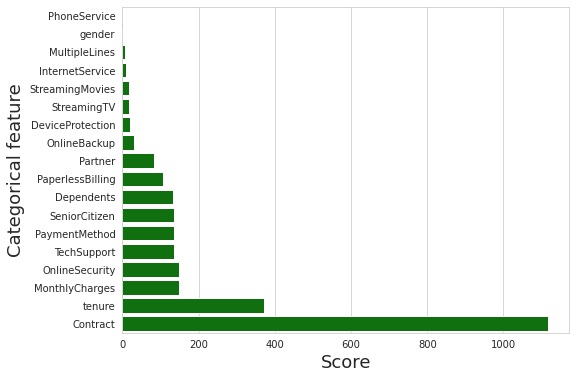

In [53]:
# plot the scores of features
plt.figure(figsize=(8,6))
datset1 = pd.DataFrame()
datset1['feature'] = X1.columns[ range(len(sf_fit1.scores_))]
datset1['scores'] = sf_fit1.scores_
datset1 = datset1.sort_values(by='scores', ascending=True)
sns.barplot(datset1['scores'], datset1['feature'], color='green')
sns.set_style('whitegrid')
plt.ylabel('Categorical feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show();